# Dynamics of the XXZ spin chain

Tutorial and Python codes by Nicolas Macé (mace@irsamc.ups-tlse.fr)

The model and parameters used are the ones of https://arxiv.org/abs/1801.08949 (notice that they are **different** from the ones used in the `XXZ_static_properties` notebook; in particular, here we use Pauli rather than spin operators), and the code uses the `quspin` library, see https://arxiv.org/abs/1804.06782.

In [1]:
from quspin.operators import hamiltonian,exp_op,quantum_operator # Hamiltonians and operators
from quspin.basis import spin_basis_1d # Hilbert space spin basis
from quspin.tools.measurements import obs_vs_time, ent_entropy
import numpy as np
import matplotlib.pyplot as plt

### Uncomment if you run into OpenMP issues
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## XXZ Hamiltonian and observables
We study here the XXZ spin chain, in presence of disorder and interactions.
Let us start with routines building the Hamiltonian and different observables.
We build the Hamiltonian in two steps: first the clean part H0, which is unchanged from one disorder realization to the other, and then the full Hamiltonian H, including random external fields.

In [2]:
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

def cleanXXZ_operator(L, Delta):
    """
    Return the clean XXZ Hamiltonian with uniform external field set to 1
    Delta: strength of the zz interaction
    """
    Jxy = 1.0 # xy interaction
    basis = spin_basis_1d(L, pauli=1, Nup=L//2) # zero magnetisation sector
    # define operators with OBC using site-coupling lists
    J_zz = [[Delta, i, i+1] for i in range(L-1)] # OBC
    J_pm = [[Jxy/2.0, i, i+1] for i in range(L-1)] # OBC
    # list of the couplings of H0
    operator_list_0 = [["+-",J_pm],["-+",J_pm],["zz",J_zz]]
    # create operator dictionary for quantum_operator class
    operator_dict = dict(H0=operator_list_0)
    # add keys for local potential in each site
    for i in range(L):
        # external fields with dummy value 1 (could be anything except 0)
        operator_dict["z"+str(i)] = [["z",[[1.,i]]]]
    # setting up operator
    H_op = quantum_operator(operator_dict, basis=basis, dtype=np.float64, **no_checks)
    return H_op

def observables(H0):
    """
    Return the observables we will need to perform measurements
    """
    L = H0.basis.L
    iV, iW = L//3-1, L-L//3
    V_list = [["z",[[1.0,iV]]]]
    W_list = [["z",[[1.0,iW]]]]
    # expectation value over Neel(t) is the (unnormalized) imbalance
    I_Neel_couplings = [[(-1)**(i+1), i] for i in range(L)]
    I_Neel_list = [["z", I_Neel_couplings]]

    V = hamiltonian(V_list, [], basis=H0.basis, **no_checks)
    W = hamiltonian(W_list, [], basis=H0.basis, **no_checks)
    I_Neel = hamiltonian(I_Neel_list, [], basis=H0.basis, **no_checks)
    return V, W, I_Neel

def disorderedXXZ_hamiltonian(H0, h, seed):
    """
    Add random external fields to the H0 operator, and return the Hamiltonian.
    """
    state = np.random.RandomState(seed)
    # will hold the on-site potential for each realization
    params_dict = dict(H0=1.0)
    for j in range(H0.basis.L):
        params_dict["z"+str(j)] = state.uniform(-h, h)
    # create the Hamiltonian
    H = H0.tohamiltonian(params_dict)
    return H

## Initial state
To probe thermalization property, we want to prepare the system in a non-entangled, high energy initial state. Here we adopt the commonly used Neel state.

In [3]:
def product_state(H0: quantum_operator, state_str):
    """
    Return a product state in the computational basis,
    given as a string of zeros and ones.
    """
    i = H0.basis.index(state_str)
    psi_0 = np.zeros(H0.basis.Ns)
    psi_0[i] = 1.
    return psi_0

def neel(H0: quantum_operator):
    """
    Return the Neel state
    """
    L = H0.basis.L
    # string which represents the initial state
    s_Neel = ''.join('01' for i in range(L//2))
    return product_state(H0, s_Neel)

To compute the various dynamical observables exactly, two options are available: we can either fully diagonalize the Hamiltonian (pros: fast, lets us access arbitrarily large times, cons: limited to small system sizes by the large memory requirement of storing all the eigenstates), or we can perform the time evolution iteratively, using e.g. a Krylov scheme (pros: can handle larger system sizes than full diagonalization, cons: limited to relatively short timescales). We adopt here the first approach. An alternative iterative implementation of the OTOC computation is available under `lib/XXZ.py` for you to try out.

## Time loop
Let us now write the main part of the code: the time loop computing the various observables. We chose here to focus on three observables: 
1. the spin imbalance
$$
    I(\psi_0, t) = \frac{1}{L} \sum_{j=1}^L \langle \psi_0 | \sigma_j^z(t) \sigma_j^z(0) | \psi_0 \rangle
$$
2. The half-chain von Neumann entanglement entropy
$$
    S(\psi_0, t) = -\text{Tr}\left(\rho(t) \log \rho(t)\right)
$$
3. The out of time ordered correlator
$$
    \text{OTOC}(\psi_0, t) = \langle \psi_0 | W^\dagger(t) V^\dagger(0) W(t) V(0) | \psi_0 \rangle
$$
where here we chose $V = \sigma_i^z$, $W = \sigma_j^z$, $i=L/3$, $j = L-i-1$.

In [4]:
def get_U(diagH, P, t):
    """
    Return the evolution operator at time t
    """
    diagU = np.exp(-1j*t*diagH)
    return P @ np.diag(diagU) @ np.conj(P).T

def time_loop(H0, H, times):
    """
    Do the time loop.
    H0: clean XXZ Hamiltonian
    H: disordered one
    
    Return: OTOC, Imbalance (from Neel state), half-chain entanglement entropy
    """
    L = H0.basis.L
    # full diag
    diagH, P = H.eigh()
    # initial state
    psi_0 = neel(H0)
    # operators needed for measurements
    V, W, I_Neel = observables(H0)
    Vpsi_0 = V.dot(psi_0)
    Wb = W.H
    OTOC, I, ent = [], [], []
    for cur_t in times:
        U = get_U(diagH, P, cur_t)
        ##### time evolved state
        Upsi = U.dot(psi_0)
        ##### OTOC
        U = get_U(diagH, P, cur_t)
        Ub = get_U(diagH, P, -cur_t)
        # rhs of the OTOC
        VUbWUVpsi = V.dot(Ub.dot(W.dot(U.dot(Vpsi_0))))
        # lhs of the OTOC
        UbWbUpsi = Ub.dot(Wb.dot(Upsi))
        cur_OTOC = UbWbUpsi.conj() @ VUbWUVpsi
        OTOC.append(cur_OTOC)
        ##### Imbalance
        cur_I = (Upsi.conj() @ I_Neel.dot(Upsi))/L
        I.append(cur_I)
        ##### half-chain entanglement entropy
        res = ent_entropy(Upsi, H0.basis)
        ent.append(res['Sent']/np.log(2))
    return OTOC, I, ent

# Chaotic regime
In the chaotic regime, the imbalance decays very fast, the OTOC decays exponentially, and the entanglement entropy grows linearly until it reaches its system-size dependant saturation value.

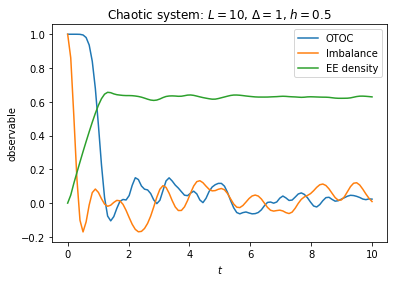

In [5]:
# parameters
L = 10
Delta = 1
h = 0.5
Nseeds = 20
times = np.linspace(0, 10, num=100, endpoint=True)
# Hamiltonian
H0 = cleanXXZ_operator(L, Delta)
# disorder realizations
Hs = [disorderedXXZ_hamiltonian(H0, h, seed) for seed in range(Nseeds)]
obs = zip(*[time_loop(H0, H, times) for H in Hs])

### plot
labels = ['OTOC', 'Imbalance', 'EE density']
for cur_obs, label in zip(obs, labels):
    mean_obs = np.mean(cur_obs, axis=0)
    plt.plot(times, mean_obs.real, label=label)
plt.title(f'Chaotic system: $L={L}$, $\\Delta={Delta}$, $h={h}$')
plt.xlabel('$t$')
plt.legend()
plt.ylabel('observable')
plt.show()

# Anderson localized regime
In the Anderson localized phase, all three observables saturate, hinting at the absence of thermalization. Moreover, the saturation value is system size independant.

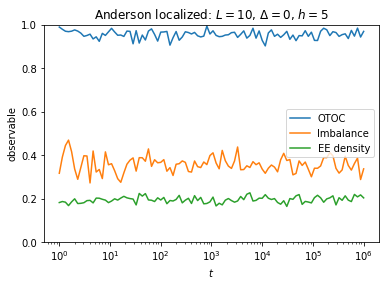

In [6]:
# parameters
L = 10
Delta = 0
h = 5
Nseeds = 20
times = np.logspace(0, 6, num=100, endpoint=True)
# Hamiltonian
H0 = cleanXXZ_operator(L, Delta)
# disorder realizations
Hs = [disorderedXXZ_hamiltonian(H0, h, seed) for seed in range(Nseeds)]
obs = zip(*[time_loop(H0, H, times) for H in Hs])  

### plot
fig, ax = plt.subplots()
labels = ['OTOC', 'Imbalance', 'EE density']
for cur_obs, label in zip(obs, labels):
    mean_obs = np.mean(cur_obs, axis=0)
    ax.plot(times, mean_obs.real, label=label)
plt.title(f'Anderson localized: $L={L}$, $\\Delta={Delta}$, $h={h}$')
plt.xlabel('$t$')
plt.legend()
plt.ylabel('observable')
ax.set_xscale('log')
ax.set_ylim(0, 1)
plt.show()

# MBL regime
In the MBL phase, the imbalance quickly saturates to a non-zero value. The entanglement entropy grows logarithmically towards a volumic saturation value, while the OTOC decays as a power-law until it reaches a finite value.

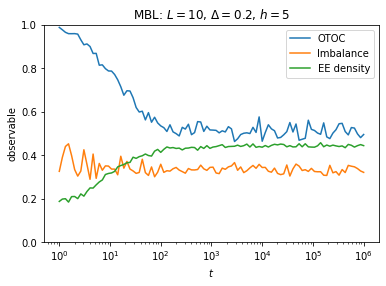

In [7]:
# parameters
L = 10
Delta = 0.2
h = 5
Nseeds = 20
times = np.logspace(0, 6, num=100, endpoint=True)
# Hamiltonian
H0 = cleanXXZ_operator(L, Delta)
# observables
Hs = [disorderedXXZ_hamiltonian(H0, h, seed) for seed in range(Nseeds)]
obs = zip(*[time_loop(H0, H, times) for H in Hs])  


### plot
fig, ax = plt.subplots()
labels = ['OTOC', 'Imbalance', 'EE density']
for cur_obs, label in zip(obs, labels):
    mean_obs = np.mean(cur_obs, axis=0)
    ax.plot(times, mean_obs.real, label=label)
plt.title(f'MBL: $L={L}$, $\\Delta={Delta}$, $h={h}$')
plt.xlabel('$t$')
plt.legend()
plt.ylabel('observable')
ax.set_xscale('log')
ax.set_ylim(0, 1)
plt.show()